In [121]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm
from sklearn.cross_decomposition import CCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import LeaveOneOut

In [2]:
GLOVE_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained/glove.6B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
EMBEDDING_PATH = '../data/word_embedding_6B_300D.pickle'

Read the concept activation vectors from the Broden dataset as a dictionary

In [3]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

Extract the word embeddings from the GloVe dataset. The word embeddings are stored in a dictionary, with the word as key and vector as value, and in a matrix (400 000 x 300). The dataset contains about 400K words.

In [4]:
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as handle:
        embedding_dict = pickle.load(handle)

    glove_embedding_matrix = np.load('../data/glove_embedding_matrix.npy')
else:
    embedding_dict = {}
    glove_embedding_matrix = np.asarray(range(300)).reshape(1,-1)

    with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
        for line in tqdm(f):
            
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vector

            glove_embedding_matrix = np.append(glove_embedding_matrix, vector.reshape(1,-1),0)
                        
    with open(EMBEDDING_PATH, 'wb') as handle:
        pickle.dump(embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    glove_embedding_matrix = glove_embedding_matrix[1:]   
    np.save('../data/glove_embedding_matrix.npy', glove_embedding_matrix)

Select the concepts from the Broden dataset, which are also available as word embedding. Several concepts in the Broden dataset end with _'-s'_. This is removed to get more concepts linked with an embedding. 

In [333]:
concepts = list(cavs_broden.keys())

# create a matrix of all cavs
cav_matrix = cavs_broden[concepts[0]]['cav']
for i in range(1, len(concepts)):
    cav = cavs_broden[concepts[i]]['cav']
    cav_matrix = np.concatenate((cav_matrix, cav), 0)

In [334]:
cav_matrix.shape

(722, 2048)

Remove the '-s' from the _scene_ concepts and store the matching cavs with the word embeddings. The index is stored to remove the unavailable concepts from the CAV matrix

In [335]:
concepts = [c[:-2] if c[-2:] == '-s' else c for c in concepts]
concepts = list(set(concepts))

embedding_concepts = [(idx, c) for idx, c in enumerate(concepts) if c in embedding_dict.keys()]

# store the indices of concepts which are present in both datasets
embedding_idxs = [ix for ix, n in embedding_concepts]

In [336]:
print("The amount of CAVs with a corresponding word embedding: ", len(embedding_idxs))

The amount of CAVs with a corresponding word embedding:  418


In [337]:
cavs_with_embedding = cav_matrix[embedding_idxs]

In [338]:
cavs_with_embedding.shape

(418, 2048)

Create a matrix of the word embeddings for the concepts which also have a CAV.

In [339]:
emb_with_cav = embedding_dict[embedding_concepts[0][1]].reshape(1,-1) #reshape the vector to a single row vector
for i in range(1, len(embedding_concepts)):
    word_vec = embedding_dict[embedding_concepts[i][1]].reshape(1,-1)
    emb_with_cav = np.concatenate((emb_with_cav, word_vec))

In [340]:
emb_with_cav.shape

(418, 300)

Randomly sample 10% of the data for testing. Instead of using train_test_split, random indices are samples to backtrack which array belongs to which concept.

In [13]:
indices = list(range(len(emb_with_cav)))

In [14]:
test_idxs = np.asarray(random.sample(indices, 42))

Divide the matrices into train and test data with a 10% split

In [154]:
# use the GloVe word embeddings as input data
X_train = np.delete(emb_with_cav, test_idxs, axis=0)
X_test = emb_with_cav[test_idxs]
    
# use the CAVs as 'labels' for the word embedding
y_train = np.delete(cavs_with_embedding, test_idxs, axis=0)
y_test = cavs_with_embedding[test_idxs]

In [387]:
n_concepts = 20

test_concepts = [tc for ix, tc in embedding_concepts[:n_concepts]]

test_embeddings = emb_with_cav[:n_concepts]
test_cavs = cavs_with_embedding[:n_concepts]

Initialize a canonical correlation model

In [388]:
n_dimensions = 2
cca = CCA(n_components = n_dimensions, scale = True, max_iter = 10000, tol=1e-06)

In [389]:
cca.fit(test_embeddings, test_cavs)

CCA(copy=True, max_iter=10000, n_components=2, scale=True, tol=1e-06)

The transform function of the CCA does not seem to work properly as the data is not scaled. Therefore, the data is manually transformed by applying the dot product of the fitted weights and the input data after which it is scaled.

In [390]:
test_embeddings = normalize(emb_with_cav[:25], axis=0)
test_cavs = normalize(cavs_with_embedding[:25], axis = 0)

test_emb_c = np.dot(test_embeddings, cca.x_rotations_)
test_cavs_c = np.dot(test_cavs, cca.y_rotations_)

test_emb_c = scale(test_emb_c)
test_cavs_c = scale(test_cavs_c)

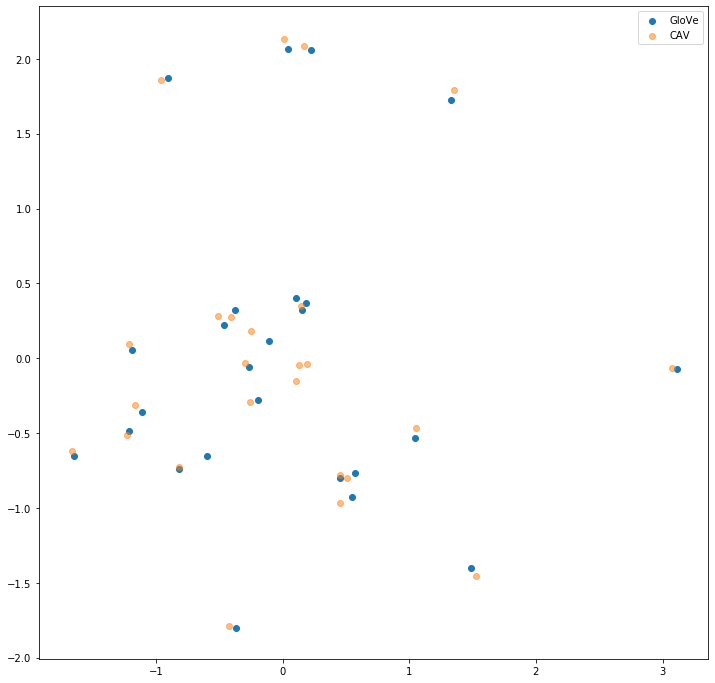

In [392]:
plt.figure(figsize=(8,8))
plt.scatter(test_emb_c[:,0], test_emb_c[:,1], label='GloVe', alpha = 1)
plt.scatter(test_cavs_c[:,0], test_cavs_c[:,1], label='CAV', alpha = 0.5)

# for i, txt in enumerate(test_concepts):
#     plt.annotate(str(txt), (test_emb_c[:,0][i], test_emb_c[:,1][i]))
#     plt.annotate(str(txt), (test_cavs_c[:,0][i], test_cavs_c[:,1][i]))


plt.legend()
plt.show()

## Perform Leave-One-Out cross validation

In [467]:
def Transform(x, rotation):
    
    x_n = normalize(x, axis = 0)
    x_c = np.dot(x_n, rotation)
    #x_s = scale(x_c)
    
    return x_c

In [508]:
num_concepts = 100

test_idxs = np.asarray(random.sample(range(len(emb_with_cav)), num_concepts))
test_concepts

glove_embeddings = emb_with_cav[test_idxs]
cavs_vector = cavs_with_embedding[test_idxs]

In [509]:
loo = LeaveOneOut()

n_dim = 50
cca2 = CCA(n_components = n_dim, scale = True, max_iter = 10000, tol=1e-06)

In [510]:
loo.get_n_splits(glove_embeddings)

100

In [511]:
correct = 0

for train_index, test_index in tqdm(loo.split(glove_embeddings)):
    #print(train_index, test_index)
    test_embeddings_loo = glove_embeddings[train_index]
    test_cavs_loo = cavs_vector[train_index]
    
    cca2.fit(test_embeddings_loo, test_cavs_loo)
    
    x_emb = Transform(glove_embeddings, cca2.x_rotations_)
    #y_cav = Transform(cavs_vector[test_index], cca2.y_rotations_)
    y_cav = normalize(test_cavs_loo, axis=0)
    y_cav = np.dot(y_cav, cca2.y_rotations_)
    y_cav_mean = y_cav.mean()
    y_cav_std = y_cav.std()
    
    nbrs = NearestNeighbors(n_neighbors=1, radius= 1, algorithm='auto').fit(x_emb)
    
    y_cav_test = normalize(cavs_vector[test_index])
    y_cav_test = np.dot(y_cav_test, cca2.y_rotations_)
    #y_cav_test = (y_cav_test - y_cav_mean) / y_cav_std
    #print(y_cav_test)
    
    distances, indices = nbrs.kneighbors(y_cav_test)
    
    if test_index.item() == indices[0][0]:
        correct +=1
    #print(test_index.item(), ': ', indices[0][0])
    
#     plt.figure(figsize=(6,6))
#     plt.scatter(x_emb[:,0], x_emb[:,1], label='GloVe', alpha = 0.5)
#     plt.scatter(y_cav_test[:,0], y_cav_test[:,1], label='LOO CAV', alpha = 0.5)

#     for txt in range(num_concepts):
#         plt.annotate(str(txt), (x_emb[:,0][txt], x_emb[:,1][txt]))
#     plt.annotate(str(test_index.item()), (y_cav_test[:,0], y_cav_test[:,1]))

#     plt.legend()
#     plt.show()
print("Total accuracy: ", round(correct/num_concepts * 100, 3))


Total accuracy:  14.0


In [442]:
correct

5

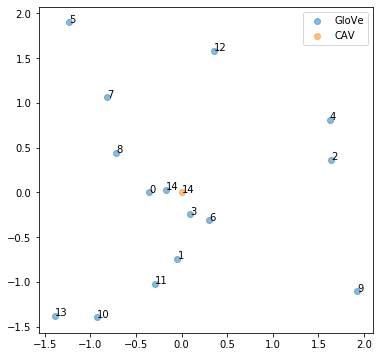

In [215]:
y_cav.shape

(1, 2)

In [142]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(test_emb_c)

In [143]:
distances, indices = nbrs.kneighbors(test_cavs_c)

In [145]:
indices.shape

(50, 1)

In [146]:
correct = [i for ix, i in enumerate(indices) if ix == i]

In [149]:
accuracy = len(correct)/len(indices)
print(accuracy)

0.94


In [182]:
test_embeddings_loo.shape

(9, 300)

In [203]:
cca2.x_rotations_.shape

(300, 2)

In [351]:
ccc = CCA(n_components = n_dim, scale = True, max_iter = 10000, tol=1e-06)

In [352]:
test_x = emb_with_cav[:10]
test_y = cavs_with_embedding[:10]

In [353]:
ccc.fit(test_x, test_y)

CCA(copy=True, max_iter=10000, n_components=2, scale=True, tol=1e-06)

In [354]:
test_x_c = Transform(test_x, ccc.x_rotations_)
test_y_c = Transform(test_y, ccc.y_rotations_)

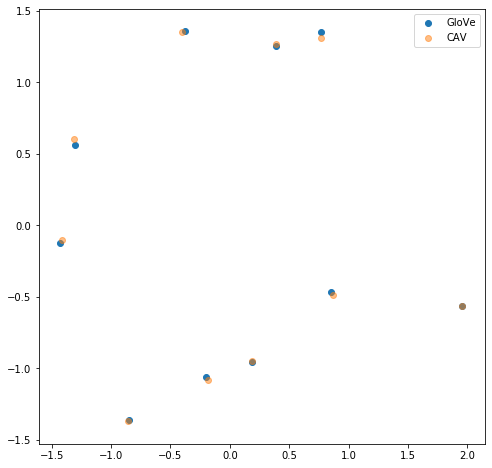

In [355]:
plt.figure(figsize=(8,8))
plt.scatter(test_x_c[:,0], test_x_c[:,1], label='GloVe', alpha = 1)
plt.scatter(test_y_c[:,0], test_y_c[:,1], label='CAV', alpha = 0.5)

# for i, txt in enumerate(test_concepts):
#     plt.annotate(str(txt), (x_emb[:,0][i], x_emb[:,1][i]))
#     plt.annotate(str(txt), (y_cav[:,0][i], y_cav[:,1][i]))

plt.legend()
plt.show()

In [419]:
glove_embeddings.mean()

-0.0036850746

In [211]:
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(test_x_c)

In [212]:
distances, indices = nn.kneighbors(test_y_c)

In [213]:
indices

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [369]:
arr = np.arange(20).reshape(4,-1)
arr

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [376]:
glove_embeddings[train_index].shape

(9, 300)